In [9]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from utils.data import COCOAEDataset, collate_fn
from utils.transforms import get_transform
from utils.transforms import ResizeTransform
from noise.scheduler import NoiseScheduler, mask_image
# import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset = COCOAEDataset(root="coco/images/train2017/",
                        annFile="coco/annotations/ann2017/captions_train2017.json",
                        transform=get_transform(),
                        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased', cache_dir='cache/'),
                        ignore_cache=False,
                        train=True)

Loading cached annotations...


In [12]:
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=True,
                        collate_fn=collate_fn(dataset.tokenizer.pad_token_id),
                        pin_memory=True)

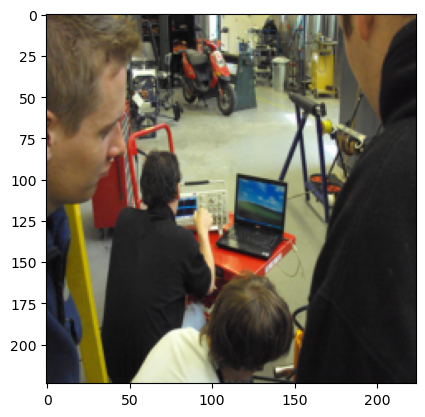

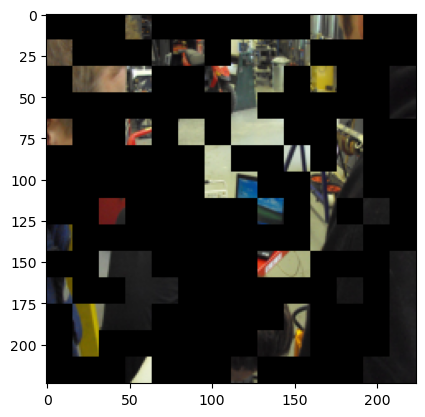

[CLS] a crew of mechanics tune up an engine with a laptop pc and on oscilloscope. [SEP]


In [27]:
for images, captions in dataloader:
    plt.imshow(images.squeeze().permute(1, 2, 0).numpy())
    plt.show()
    masked, mask = mask_image(images, 16)
    plt.imshow(masked.squeeze().permute(1, 2, 0).numpy())
    plt.show()
    print(dataset.tokenizer.decode(captions.squeeze()))
    break